# Задание 4. Модели линейной регрессии (часть I)

## Цель задания:
### 1. Построить модель парной линейной  регрессии 
### 2. Построить модель множественной линейной регрессии 
### 3. Реализовать пошаговый отбор переменных множественной модели
### 4. Провести первичную диагностику регресионных моделей
### 5. Дать экономическую интерпретацию полученным результатам

## Цель исследования - выявить показатели, влияющие на темп роста ВВП

## 1.Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

/home/maxime/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt # графическая библиотека

In [5]:
from __future__ import division #  деление с дробной частью (модуль из Python 3)

## 2.Загрузка необходимых файлов

In [6]:
pd.set_option('display.max_colwidth',-1)# опция позволяет читать текстовые поля в "необрезанном виде"

In [7]:
imf=pd.read_csv('/home/maxime/Documentos/Econometrics/imf.csv')# загрузка данных IMF в dataframe

In [8]:
wb=pd.read_csv('/home/maxime/Documentos/Econometrics/wb.csv')# загрузка данных IMF в dataframe

In [9]:
ind=pd.read_csv('/home/maxime/Documentos/Econometrics/indicators.csv')#загрузка базы индикаторов в dataframe

## 3. Выбор показателей для дальнейшего анализа и преобразование dataframe в необходимый формат

### Для более компактного представления результатов приведен готовый список используемых показателей.  Каждый слушатель самостоятельно формирует  перечень экономических показателей

In [10]:
ind.iloc[[23,32,33,35,44,45,48,51,59,75,78],:]

,Code,Indicator,Source
23,NY.GNS.ICTR.ZS,Gross savings (% of GDP),wb
32,FM.LBL.BMNY.GD.ZS,Broad money (% of GDP),wb
33,FM.LBL.BMNY.ZG,Broad money growth (annual %),wb
35,NGDP_RPCH,"Gross domestic product, constant prices/Percent change",imf
44,PPPPC,"Gross domestic product per capita, current prices/Purchasing power parity; international dollars",imf
45,NGAP_NPGDP,Output gap in percent of potential GDP/Percent of potential GDP,imf
48,NID_NGDP,Total investment/Percent of GDP,imf
51,PCPIPCH,"Inflation, average consumer prices/Percent change",imf
59,LUR,Unemployment rate/Percent of total labor force,imf
75,GGXWDG_NGDP,General government gross debt/Percent of GDP,imf


In [11]:
list_ind_imf=list(ind.iloc[[35,44,45,48,51,59,75,78],0])
# выберем показатели из базы IMF

In [12]:
list_ind_wb=list(ind.iloc[[23,32,33],0])
# выберем показатели из базы IMF 

In [13]:
imf_reduced=imf[imf['WEO Subject Code'].isin(list_ind_imf)].drop(imf.columns[[0,3,4,5,6,7,8,53,55]],axis=1)
# далее все делаем по аналогии с предыдущим заданием

In [14]:
col_=[str(i) for i in range(1980,2018)]
imf_long=pd.melt(imf_reduced,id_vars=['ISO','WEO Subject Code','continent'],value_vars=col_)

In [15]:
imf_long.columns=['Country','Indicator','Continent','Year','Value']

In [16]:
imf_long['Value']=imf_long['Value'].apply(lambda x:str(x).replace(',',''))
imf_long['Value']=pd.to_numeric(imf_long['Value'],errors='coerce')
imf_long['Year']=pd.to_numeric(imf_long['Year'],errors='coerce')

### Для проведения ргрессионного анализа сформируем пространственную выборку по данным 2016 г.

In [17]:
imf_long=imf_long[imf_long.Year==2016].drop(columns='Year')

In [18]:
imf_wide=imf_long.pivot_table(index=['Country','Continent'],columns=['Indicator'],values=['Value'])
# преобразование в широкий формат по аналогии с первым заданием

In [19]:
col_names=['Country','Continent']+list(imf_wide.columns.get_level_values(1))

In [20]:
imf_wide.columns=imf_wide.columns.get_level_values(0) 
imf_wide=imf_wide.reset_index()

In [21]:
imf_wide.columns=col_names

In [22]:
wb_reduced=wb[wb['Series Code'].isin(list_ind_wb)].drop(wb.columns[[0,2,63,64]],axis=1)

In [23]:
col_=[str(i) for i in range(1960,2017)]
wb_long=pd.melt(wb_reduced,id_vars=['Country Code','Series Code'],value_vars=col_)

In [24]:
wb_long.columns=['Country','Indicator','Year','Value']

In [25]:
wb_long['Value']=pd.to_numeric(wb_long['Value'],errors='coerce')
wb_long['Year']=pd.to_numeric(wb_long['Year'],errors='coerce')

In [26]:
wb_long.dtypes

Country      object 
Indicator    object 
Year         int64  
Value        float64
dtype: object

In [27]:
wb_long=wb_long[wb_long.Year==2016].drop(columns='Year')
# создадим вспомогательный dataframe для дальнейшего преобразования в широкий формат

In [28]:
wb_wide=wb_long.pivot_table(index=['Country'],columns=['Indicator'],values=['Value'])
# преобразование в широкий формат по аналогии с первым заданием

In [29]:
col_names=['Country']+list(wb_wide.columns.get_level_values(1))

In [30]:
wb_wide.columns=wb_wide.columns.get_level_values(0) 
wb_wide=wb_wide.reset_index()

In [31]:
wb_wide.columns=col_names

In [32]:
econ_model=imf_wide.join(wb_wide,lsuffix='imf',rsuffix='wb')
# объединим массив IMF и массив WB, используя функцию join
# объединение осуществляется по полю Country (общее поле для обоих массивов)

In [33]:
econ_model.drop(columns='Countrywb',inplace=True)
# оставим одно поле с названием стран

In [34]:
econ_model.head()

,Countryimf,Continent,BCA_NGDPD,GGXWDG_NGDP,LUR,NGAP_NPGDP,NGDP_RPCH,NID_NGDP,PCPIPCH,PPPPC,FM.LBL.BMNY.GD.ZS,FM.LBL.BMNY.ZG,NY.GNS.ICTR.ZS
0,ABW,Americas,5.018,84.677,7.7,NaN,-0.124,NaN,-0.888,36507.036,NaN,9.500907,NaN
1,AFG,Asia,7.253,7.823,NaN,NaN,2.164,18.533,4.384,1915.519,34.448130,9.725428,18.096194
2,AGO,Africa,-4.780,75.253,NaN,NaN,-2.580,27.215,30.694,7085.996,41.844759,14.302695,3.049233
3,ALB,Europe,-7.563,73.187,15.2,NaN,3.352,24.277,1.275,11830.877,85.643310,3.887472,14.540693
4,ARE,Asia,3.706,20.217,NaN,NaN,2.988,27.143,1.617,68750.352,90.515094,NaN,23.757937


### Проведем предварительный отбор переменных с учетом количества nan наблюдений для каждого показателя. Не существует формальных критериев выбора переменных,  данный этап анализа необходимо производить с учетом целей и задач всего исследования.

In [35]:
econ_model.isnull().sum()

Countryimf           0  
Continent            0  
BCA_NGDPD            2  
GGXWDG_NGDP          5  
LUR                  81 
NGAP_NPGDP           165
NGDP_RPCH            0  
NID_NGDP             18 
PCPIPCH              2  
PPPPC                1  
FM.LBL.BMNY.GD.ZS    33 
FM.LBL.BMNY.ZG       67 
NY.GNS.ICTR.ZS       28 
dtype: int64

### Переменныe LUR, NGAP_NPGDP,FM.LBL.BMNY.ZG содержат большое количество nan наблюдений, целесообразно удалить из списка данные переменные (не без сожаления).

In [36]:
ind_del=['LUR','NGAP_NPGDP','FM.LBL.BMNY.ZG']

In [37]:
econ_model.drop(columns=ind_del,inplace=True)

### Далее необходимо сделать выбор: либо удалить страны с хотя бы одним nan наблюдением, либо удалить показатели  FM.LBL.BMNY.GD.ZS и NID_NGDP. 

### Посмотрим на переменную FM.LBL.BMNY.GD.ZS. Речь идет о показателе отношения денежной массы к ВВП. Это - важный показатель, однако мы видим, что по многим крупным странам, он имеет пустые значения.

In [38]:
econ_model[econ_model['FM.LBL.BMNY.GD.ZS'].isnull()]

,Countryimf,Continent,BCA_NGDPD,GGXWDG_NGDP,NGDP_RPCH,NID_NGDP,PCPIPCH,PPPPC,FM.LBL.BMNY.GD.ZS,NY.GNS.ICTR.ZS
0,ABW,Americas,5.018,84.677,-0.124,NaN,-0.888,36507.036,NaN,NaN
10,AZE,Asia,-3.606,50.711,-3.100,24.930,12.562,17397.067,NaN,26.202151
13,BEN,Africa,-9.417,49.678,3.969,24.594,-0.809,2177.231,NaN,24.138765
18,BHS,Americas,-7.329,50.482,-1.690,25.554,-0.347,31672.405,NaN,23.934501
29,CAN,Americas,-3.212,91.147,1.414,23.180,1.422,46657.892,NaN,19.221366
43,DEU,Europe,8.507,67.900,2.157,19.660,0.392,48844.163,NaN,11.922524
45,DMA,Americas,0.824,71.748,2.638,19.191,0.026,11393.589,NaN,27.597278
55,FIN,Europe,-0.342,62.949,2.477,22.019,0.389,42597.772,NaN,22.871145
58,FSM,Oceania,3.259,25.293,2.935,NaN,0.472,3271.579,NaN,23.497008
59,GAB,Africa,-9.907,64.199,2.082,34.174,2.086,18092.826,NaN,22.410288


### Посмотрим на показатель NID_NGDP - отношение общего объема инвестиций к ВВП. Среди стран, у которых отсуствует  данный показатель, нет крупных экономик. По этой причине можно условно пренебречь данной группой стран. 

In [39]:
econ_model[econ_model['NID_NGDP'].isnull()]

,Countryimf,Continent,BCA_NGDPD,GGXWDG_NGDP,NGDP_RPCH,NID_NGDP,PCPIPCH,PPPPC,FM.LBL.BMNY.GD.ZS,NY.GNS.ICTR.ZS
0,ABW,Americas,5.018,84.677,-0.124,NaN,-0.888,36507.036,NaN,NaN
58,FSM,Oceania,3.259,25.293,2.935,NaN,0.472,3271.579,NaN,23.497008
80,IRQ,Asia,-7.837,66.028,13.062,NaN,0.525,17172.841,121.358218,22.115107
91,KIR,Oceania,19.440,22.879,1.140,NaN,1.917,1922.277,40.340678,29.950400
95,LAO,Asia,-13.008,58.449,7.023,NaN,1.597,6878.326,90.400464,NaN
96,LBN,Asia,-21.719,145.454,1.741,NaN,-0.816,19098.377,NaN,11.947422
97,LBR,Africa,-14.141,28.296,-1.630,NaN,8.844,1268.674,71.484048,24.949626
111,MHL,Oceania,7.576,30.042,3.621,NaN,-1.508,3473.273,NaN,17.291557
112,MKD,Europe,-2.726,39.538,2.910,NaN,-0.239,14681.253,267.388363,6.320786
130,NRU,Oceania,1.711,64.955,10.404,NaN,8.150,11552.959,46.904427,NaN


### Исключим показатель FM.LBL.BMNY.GD.ZS и удалим страны, в которых присутствуют nan наблюдения

In [40]:
econ_model.drop(columns='FM.LBL.BMNY.GD.ZS',inplace=True)

In [41]:
econ_model.dropna(inplace=True)

In [42]:
econ_model.shape
## В итооге осталась 161 страна и 8 показателей

(147, 9)

### Преобразуем переменную PPPPC в логарифмическую шкалу (по аналогии с Заданием 3)

In [43]:
econ_model['PPPPC']=np.log(econ_model['PPPPC'])

In [44]:
econ_model.head()

,Countryimf,Continent,BCA_NGDPD,GGXWDG_NGDP,NGDP_RPCH,NID_NGDP,PCPIPCH,PPPPC,NY.GNS.ICTR.ZS
1,AFG,Asia,7.253,7.823,2.164,18.533,4.384,7.557744,18.096194
2,AGO,Africa,-4.780,75.253,-2.580,27.215,30.694,8.865876,3.049233
3,ALB,Europe,-7.563,73.187,3.352,24.277,1.275,9.378468,14.540693
4,ARE,Asia,3.706,20.217,2.988,27.143,1.617,11.138237,23.757937
6,ARM,Asia,-2.258,51.862,0.261,19.727,-1.406,9.065648,12.403776


In [45]:
econ_model.isnull().sum()

Countryimf        0
Continent         0
BCA_NGDPD         0
GGXWDG_NGDP       0
NGDP_RPCH         0
NID_NGDP          0
PCPIPCH           0
PPPPC             0
NY.GNS.ICTR.ZS    0
dtype: int64

## 4.Модель парной линейной регрессии

### В качестве зависимой переменной Y будем рассматривать показатель темпа роста ВВП - NGDP_RPCH, в качестве объясняющей переменной X возьмем отношение общего объема инвестиций к ВВП.

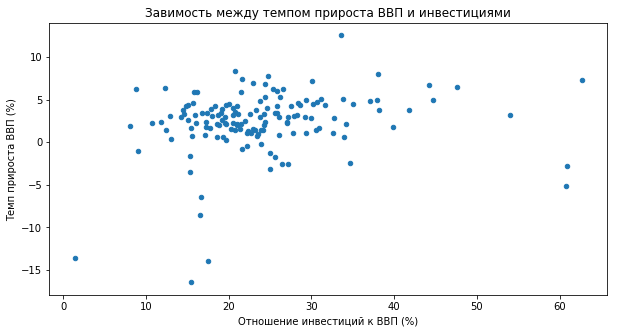

In [46]:
p=econ_model[['NGDP_RPCH','NID_NGDP']].plot.scatter(x='NID_NGDP',y='NGDP_RPCH',title=u'Завимость между темпом прироста ВВП и инвестициями',figsize=(10,5),)
p.set(xlabel=u'Отношение инвестиций к ВВП (%)',ylabel=u'Темп прироста ВВП (%)')

In [47]:
n=econ_model.shape[0] # общее число наблюдений 

In [48]:
k=2 # общее число коэффициентов регрессии с учетом свободного члена

### Будем строить регрессеонную модель, используя разные бибилиотеки. Результаты должны совпасть.

### Библиотека scipy

In [49]:
model_linear_bi=stats.linregress(econ_model['NID_NGDP'],econ_model['NGDP_RPCH'])
# вызов процедуры МНК и визуализация результатов

In [50]:
model_linear_bi

LinregressResult(slope=0.07500694043944571, intercept=0.58740416063225576, rvalue=0.19263974631582106, pvalue=0.01940627788955579, stderr=0.03172925492582547)

In [51]:
print('b0=%.4f\nb1=%.4f\nrvalue=%.4f\npvalue=%.4f\nstderr=%.4f'%(model_linear_bi.intercept,model_linear_bi.slope,
model_linear_bi.rvalue,model_linear_bi.pvalue,model_linear_bi.stderr))

b0=0.5874
b1=0.0750
rvalue=0.1926
pvalue=0.0194
stderr=0.0317


### Библиотека statsmodels

In [52]:
Y=econ_model['NGDP_RPCH']

In [53]:
X=sm.add_constant(econ_model['NID_NGDP'],prepend=True)
# добавим единичный вектор к вектору X - для плучения модели со свободной переменной

In [54]:
X.head()

,const,NID_NGDP
1,1.0,18.533
2,1.0,27.215
3,1.0,24.277
4,1.0,27.143
6,1.0,19.727


In [55]:
sm.OLS(Y,X).fit().summary()
# вызов процедуры МНК и визуализация результатов

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NGDP_RPCH   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     5.588
Date:                Wed, 05 Dec 2018   Prob (F-statistic):             0.0194
Time:                        08:43:54   Log-Likelihood:                -399.33
No. Observations:                 147   AIC:                             802.7
Df Residuals:                     145   BIC:                             808.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5874      0.824      0.713      0.477      -1.040       2.215
NID_NGDP       0.0750      0.032      2.364      0.019       0.012       0.138
==============================================================================
Omnibus:                       82.248   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              411.287
Skew:                          -2.033   Prob(JB):                     4.90e-90
Kurtosis:                      10.114   Cond. No.                         70.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Библиотека numpy

In [56]:
A=np.vstack([np.ones(n),econ_model['NID_NGDP']]).T
# добавим единичный вектор к вектору X - для плучения модели со свободной переменной

In [57]:
A[0:10]

array([[  1.   ,  18.533],
       [  1.   ,  27.215],
       [  1.   ,  24.277],
       [  1.   ,  27.143],
       [  1.   ,  19.727],
       [  1.   ,  24.343],
       [  1.   ,  24.118],
       [  1.   ,  24.93 ],
       [  1.   ,   9.   ],
       [  1.   ,  23.952]])

In [58]:
p,res,rnk,s=np.linalg.lstsq(A,np.array(Y))
# вызов процедуры МНК и визуализация результатов

In [59]:
p,res,rnk,s

(array([ 0.58740416,  0.07500694]),
 array([ 1969.72042876]),
 2,
 array([ 314.92294141,    4.4721132 ]))

### Проведем "ручной" расчет

<font size='5'>$b_1=\frac{cov(x,y)}{var(x)}$</font>

In [60]:
b1=np.mean(np.multiply((econ_model['NGDP_RPCH']-np.mean(econ_model['NGDP_RPCH'])),
(econ_model['NID_NGDP']-np.mean(econ_model['NGDP_RPCH']))))/(np.mean((econ_model['NID_NGDP']-np.mean(econ_model['NID_NGDP']))**2))

<font size='5'>$b_0=\overline{y}-\overline{x}b_1$</font>

In [61]:
b0=np.mean(econ_model['NGDP_RPCH'])-np.mean(econ_model['NID_NGDP'])*b1

In [62]:
b0,b1

(0.5874041606322657, 0.07500694043944536)

In [63]:
Y_hat=b0+b1*econ_model['NID_NGDP']
# выравненные значения переменной Y

In [64]:
Y_hat.head()

1    1.977508
2    2.628718
3    2.408348
4    2.623318
6    2.067066
Name: NID_NGDP, dtype: float64

In [65]:
resid=(Y-Y_hat)
# остатки уравнения регрессии

In [66]:
np.mean(resid)
# проверка равенства нулю среднего значения остатков

-1.7446361815538173e-15

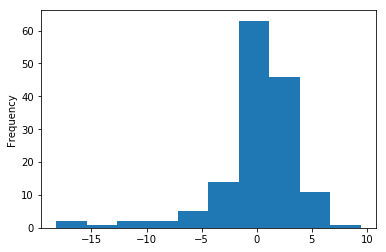

In [67]:
resid.plot(kind='hist')

In [68]:
stats.normaltest(resid)
# проверка нормальности распределения остатков

NormaltestResult(statistic=82.248245334017952, pvalue=1.3804492737634052e-18)

In [69]:
SSR=np.sum((resid)**2)
SSR
# cумма квадратов остатков уравнения регрессии

1969.7204287620832

### Коэффициент детерминации $R^2=1-\frac{SSR}{\sum(y_i-\overline{y})^2}$

In [70]:
R_sq=1-(SSR/np.sum((econ_model['NGDP_RPCH']-np.mean(econ_model['NGDP_RPCH']))**2))
R_sq
# коэффициент детерминации

0.03711007186062365

### Скорректированный коэффициент детерминации $R^2=1-\frac{(1-R^2)(n-1)}{n-k}$

In [71]:
R_sq_adjusted=1-(((1-R_sq)*(n-1))/(n-k))
R_sq_adjusted
# скорректированный коэффициент детерминации

0.030469451666559122

In [72]:
R_sq**.5
# коэффициент корреляции (парный совпадает с множественным)

0.19263974631582043

### Проверим гипотезу $H_0:\beta_1=0$

### Для этой цели рассчитаем стандартные ошибки коэффициентов регрессии  по формуле $\sigma^2(X^{'}X)^{-1}$ 

### Здесь и далее $\alpha=0.05$

In [73]:
S_2=np.dot(A.T,A)
S_2=np.linalg.inv(S_2)
S_2

array([[  4.99364809e-02,  -1.78792887e-03],
       [ -1.78792887e-03,   7.41110832e-05]])

In [74]:
std_err=((SSR/(n-k))*S_2[1,1])**.5
std_err # стандартная ошибка коэффициента регрессии

0.031729254925825484

<font size='5'>$t=\frac{b_1}{s}$</font>

In [75]:
t=b1/std_err
t # t-критерий Стьюдента

2.3639679095771879

In [76]:
2*(1-stats.t.cdf(t,n-k))# p-value

0.019406277889556511

In [77]:
delta=stats.t.ppf(.975,n-k)*std_err
delta
# построение интервальной оценки коэффициента регрессии

0.062711589313000443

In [78]:
b1-delta,b1+delta

(0.01229535112644492, 0.13771852975244581)

### Проверка значимости уравнения регрессии. В случае двумерной модели совпадает с проверкой значимости коэффициента регрессии

In [79]:
t**2 # Для парной регрессии t-критерий Стьдента в квадрате равен F- критерию Фишера-Снедекора

5.5883442775107399

### F-критерий $F=\frac{\frac{\sum(y_i-\overline{y})^2-\sum(y_i-\hat{y})^2}{(k-1)}}{\frac{\sum(y_i-\hat{y})^2}{(n-k)}}$ 

In [80]:
F=((np.var(econ_model['NGDP_RPCH'])*n-SSR)/(k-1))/(SSR/(n-k))
F# F- критерий Фишера-Снедекора

5.5883442775107248

### Функция правдоподобия $ln\lbrack\prod_{i=1}^{n}\frac{1}{\sigma\sqrt{2\pi}}exp(-\frac{(y_i-\hat{y_i})^2}{2\sigma^2})\rbrack$

In [81]:
L=(1/np.sqrt(2*np.pi*(SSR/n)))**n*np.exp(-SSR/((SSR/n)*2))
np.log(L)

-399.33221620640444

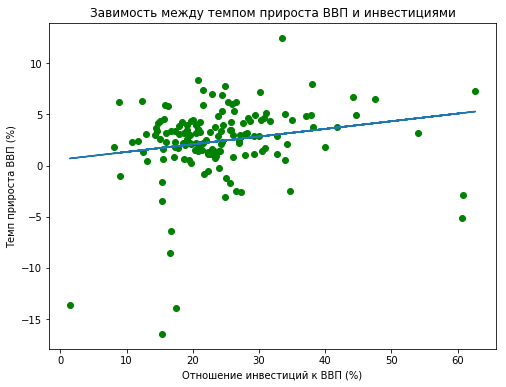

In [82]:
plt.figure(figsize=(8,6))
plt.scatter(econ_model['NID_NGDP'],econ_model['NGDP_RPCH'], c='green')
plt.plot(econ_model['NID_NGDP'],Y_hat)
plt.title(u'Завимость между темпом прироста ВВП и инвестициями')
plt.ylabel(u'Темп прироста ВВП (%)')
plt.xlabel(u'Отношение инвестиций к ВВП (%)')
#plt.show()

### Общий вывод: Уравнение регрессии значимо, о чем свидетельствуют значения F-критерия и p-value. Однако выявленная взаимосвязь  очень слабая - коэффициент детерминации равен чуть более 3%, т.е. только 3% прироста ВВП объясняется долей инвестиций ВВП. Интерпретация коэффициента регрессии - увеличение доли инвестиций в ВВП на 1 п.п. увеличивает рост ВВП на 0.07 п.п.

## 5. Модель множественной регрессии

### В качестве зависимой переменной Y будем рассматривать показатель темпа роста ВВП - NGDP_RPCH, в качестве объясняющих возьмем остальные экономические показатели (таким образом, X - уже не вектор, а матрица).

In [83]:
k_m=7 # количество независимых переменных

In [84]:
X_m=sm.add_constant(econ_model.iloc[:,[2,3,5,6,7,8]],prepend=True)
# формирование матрица независимых переменных с учетом единичного вектора

In [85]:
X_m.head()

,const,BCA_NGDPD,GGXWDG_NGDP,NID_NGDP,PCPIPCH,PPPPC,NY.GNS.ICTR.ZS
1,1.0,7.253,7.823,18.533,4.384,7.557744,18.096194
2,1.0,-4.780,75.253,27.215,30.694,8.865876,3.049233
3,1.0,-7.563,73.187,24.277,1.275,9.378468,14.540693
4,1.0,3.706,20.217,27.143,1.617,11.138237,23.757937
6,1.0,-2.258,51.862,19.727,-1.406,9.065648,12.403776


In [86]:
Y_m=np.asarray(econ_model['NGDP_RPCH'])max

In [87]:
Y_m=Y_m[:,np.newaxis]

In [88]:
Y_m.shape

(147, 1)

In [89]:
model_linear_m=sm.OLS(Y_m,X_m)
# создание модели

In [90]:
results=model_linear_m.fit()

In [91]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     14.06
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           1.73e-12
Time:                        08:43:56   Log-Likelihood:                -367.44
No. Observations:                 147   AIC:                             748.9
Df Residuals:                     140   BIC:                             769.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.5535      2.264      3.

<font size='5'>$\beta=(X^{'}X)^{-1}(X^{'}Y)$</font>

In [92]:
Betas=np.dot(np.linalg.inv(np.dot(X_m.T,X_m)),np.dot(X_m.T,Y_m))
# расчет коэффициентов регрессии

In [93]:
Betas

array([[  7.55348813e+00],
       [  7.04379635e-02],
       [ -2.01308809e-03],
       [  1.02520428e-01],
       [ -5.62982925e-02],
       [ -7.26900000e-01],
       [ -1.46476134e-03]])

In [94]:
Y_hat_m=np.dot(X_m,Betas)
# выравненные значения переменной Y

In [95]:
Y_hat_m[0:10]

array([[ 4.18159505],
       [ 1.67830596],
       [ 2.45203496],
       [ 2.33432599],
       [ 2.78362401],
       [ 2.51750641],
       [ 2.08628781],
       [ 1.91014539],
       [ 2.30427386],
       [ 1.9152273 ]])

In [96]:
resid_m=Y_m-Y_hat_m
# остатки уравнения регессии

In [97]:
np.mean(resid_m)
# среднее значение остатков незначимо отличается от нуля

1.7630643732550784e-14

In [98]:
stats.normaltest(resid_m)
# проверка нормальности распределения остатков

NormaltestResult(statistic=array([ 60.2520094]), pvalue=array([  8.24978055e-14]))

In [99]:
SSR_m=np.sum((resid_m)**2)
SSR_m
# cумма квадратов остатков уравнения регрессии

1276.3886530102911

### Проверим гипотезы $H_0:\beta_i=0$ для каждого коэффициента регрессии

### Используем тот же подход и формулы, как и в случае двумерной модели

In [100]:
S_2_m=np.linalg.inv(np.dot(X_m.T,X_m))

In [101]:
sigma_sq_m=((SSR_m/(n-k))*S_2_m)
sigma_sq_m

array([[  4.94706510e+00,   1.88080245e-02,  -1.13592565e-03,
         -3.41375741e-03,  -2.71958727e-03,  -4.58648431e-01,
         -1.67217618e-02],
       [  1.88080245e-02,   9.13784208e-04,   7.17571002e-05,
          4.16384147e-04,  -1.65428938e-05,  -3.11538731e-03,
         -2.46604523e-05],
       [ -1.13592565e-03,   7.17571002e-05,   5.84637639e-05,
          3.34175435e-05,  -2.71653615e-06,  -3.14539764e-04,
          9.38166837e-06],
       [ -3.41375741e-03,   4.16384147e-04,   3.34175435e-05,
          8.47207820e-04,  -2.19862737e-06,  -1.82152496e-03,
         -2.07067675e-05],
       [ -2.71958727e-03,  -1.65428938e-05,  -2.71653615e-06,
         -2.19862737e-06,   4.35783659e-05,   2.55029100e-04,
          6.18381790e-06],
       [ -4.58648431e-01,  -3.11538731e-03,  -3.14539764e-04,
         -1.82152496e-03,   2.55029100e-04,   5.32231585e-02,
          4.91719275e-04],
       [ -1.67217618e-02,  -2.46604523e-05,   9.38166837e-06,
         -2.07067675e-05,   6.18

In [102]:
std_err_betas=np.sqrt(sigma_sq_m.diagonal())
std_err_betas=std_err_betas[:,np.newaxis]
std_err_betas
# стандартная ошибка коэффициентов регрессии

array([[ 2.22419988],
       [ 0.03022886],
       [ 0.00764616],
       [ 0.02910683],
       [ 0.00660139],
       [ 0.23070145],
       [ 0.02315163]])

In [103]:
t_m=Betas/std_err_betas
t_m
# t-критерий для коэффицентов регрессии

array([[ 3.39604736],
       [ 2.33015584],
       [-0.26328092],
       [ 3.52221153],
       [-8.52824665],
       [-3.15082547],
       [-0.06326818]])

In [104]:
(2*(1-stats.t.cdf(np.abs(t_m),n-k_m)))
# p-value

array([[  8.90026032e-04],
       [  2.12270726e-02],
       [  7.92721154e-01],
       [  5.78262346e-04],
       [  2.17603713e-14],
       [  1.99133218e-03],
       [  9.49643197e-01]])

### Проверим значимость уравнения ререссии, гипотеза $H_0:\beta_0=\beta_1=...=\beta_k=0$ 

In [105]:
F_m=((np.var(econ_model['NGDP_RPCH'])*n-SSR_m)/(k_m-1))/(SSR_m/(n-k_m))
F_m
# F- критерий

14.062377748817029

In [106]:
R_sq_m=1-(SSR_m/np.sum((econ_model['NGDP_RPCH']-np.mean(econ_model['NGDP_RPCH']))**2))
R_sq_m
# коэффициент детерминации

0.37604252845800967

In [107]:
R_sq_adjusted=1-(((1-R_sq_m)*(n-1))/(n-k_m))
R_sq_adjusted
# скорректированный коэффициент детерминации

0.34930149396335297

In [108]:
L=(1/np.sqrt(2*np.pi*(SSR_m/n)))**n*np.exp(-SSR_m/((SSR_m/n)*2))
np.log(L)
# логарифмическая функция правдоподобия

-367.44373458552496

### Выводы: Уравнение регрессии значимо (p-value F-критерия существенно меньше уровня значимости $\alpha$).  Модель объясняет 38% вариации роста ВВП. Однако только три переменных, а именно NID_NGDP, PCPIPCH, PPPPC, оказались значимы. Интерпретация каждого из коэффициентов регрессии осуществляется по аналогии с парной моделью.

## 6. Построение модели множественной регрессии пошаговым методом

### В предыдущем разделе была рассмотрена множественная регрессионная модель, в которую вошли все независимые переменные. Однако на практике такой подход не всегда оправдан. При большом количестве переменных пользуются пошаговым методом. Это означает, что на каждом шаге мы включаем или исключаем переменные в зависимости от значимости коэффициентов регрессии (формальный критерий не всегда является окончательным решением).

### Шаг 1. Начинаем построение модели с двух переменных BCA_NGDPD и GGXWDG_NGDP

In [109]:
X_m=sm.add_constant(econ_model.iloc[:,[2,3]],prepend=True)

In [110]:
sm.OLS(Y_m,X_m).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6273
Date:                Wed, 05 Dec 2018   Prob (F-statistic):              0.536
Time:                        08:43:56   Log-Likelihood:                -401.47
No. Observations:                 147   AIC:                             808.9
Df Residuals:                     144   BIC:                             817.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.9697      0.606      4.897      0.000       1.771       4.168
BCA_NGDPD      -0.0082      0.031     -0.262      0.794      -0.070       0.054
GGXWDG_NGDP    -0.0106      0.009     -1.120      0.265      -0.029       0.008
==============================================================================
Omnibus:                       87.797   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              516.751
Skew:                          -2.126   Prob(JB):                    6.15e-113
Kurtosis:                      11.142   Cond. No.                         130.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Уравнение не значимо, что следует из значения F-критерия

### Шаг 2. Добавляем переменную NID_NGDP

In [111]:
X_m=sm.add_constant(econ_model.iloc[:,[2,3,5]],prepend=True)

In [112]:
sm.OLS(Y,X_m).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NGDP_RPCH   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2.462
Date:                Wed, 05 Dec 2018   Prob (F-statistic):             0.0650
Time:                        08:43:57   Log-Likelihood:                -398.41
No. Observations:                 147   AIC:                             804.8
Df Residuals:                     143   BIC:                             816.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8734      1.038      0.842      0.401      -1.178       2.925
BCA_NGDPD       0.0258      0.034      0.767      0.444      -0.041       0.092
GGXWDG_NGDP    -0.0081      0.009     -0.863      0.389      -0.026       0.010
NID_NGDP        0.0859      0.035      2.467      0.015       0.017       0.155
==============================================================================
Omnibus:                       82.460   Durbin-Watson:                   2.132
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              410.649
Skew:                          -2.042   Prob(JB):                     6.74e-90
Kurtosis:                      10.097   Cond. No.                         238.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Уравнение оказалась значимым, но входящие в модель переменные объясняют только 5% вариации переменной Y

### Шаг 3. Добавляем переменную PCPIPCH

In [113]:
X_m=sm.add_constant(econ_model.iloc[:,[2,3,5,6]],prepend=True)

In [114]:
sm.OLS(Y,X_m).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NGDP_RPCH   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     17.73
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           7.95e-12
Time:                        08:43:57   Log-Likelihood:                -372.34
No. Observations:                 147   AIC:                             754.7
Df Residuals:                     142   BIC:                             769.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.4128      0.875      1.615      0.109      -0.317       3.142
BCA_NGDPD       0.0278      0.028      0.986      0.326      -0.028       0.084
GGXWDG_NGDP    -0.0064      0.008     -0.820      0.413      -0.022       0.009
NID_NGDP        0.0777      0.029      2.654      0.009       0.020       0.136
PCPIPCH        -0.0529      0.007     -7.776      0.000      -0.066      -0.039
==============================================================================
Omnibus:                       49.727   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.551
Skew:                          -1.239   Prob(JB):                     9.23e-38
Kurtosis:                       7.659   Cond. No.                         241.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Включенная переменная - инфляция  - существенно улучшила качество модели. Модель  объясняет уже более 30% вариации переменной Y. На улучшение качества модели также указывают значения критериев Log-Likelihood (логарифмическая функция правдоподобия), AIC и BIC.

### Шаг 4. Добавляем переменную log (PPPPPC)

In [115]:
X_m=sm.add_constant(econ_model.iloc[:,[2,3,5,6,7]],prepend=True)

In [116]:
sm.OLS(Y,X_m).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NGDP_RPCH   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     16.99
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           3.96e-13
Time:                        08:43:57   Log-Likelihood:                -367.45
No. Observations:                 147   AIC:                             746.9
Df Residuals:                     141   BIC:                             764.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.5078      2.133      3.519      0.001       3.290      11.725
BCA_NGDPD       0.0704      0.031      2.297      0.023       0.010       0.131
GGXWDG_NGDP    -0.0020      0.008     -0.257      0.798      -0.017       0.013
NID_NGDP        0.1025      0.030      3.473      0.001       0.044       0.161
PCPIPCH        -0.0563      0.007     -8.414      0.000      -0.070      -0.043
PPPPC          -0.7256      0.233     -3.115      0.002      -1.186      -0.265
==============================================================================
Omnibus:                       60.731   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.009
Skew:                          -1.457   Prob(JB):                     3.47e-57
Kurtosis:                       8.828   Cond. No.                         611.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Включенная переменная существенно не повлияла качество модели (AIC и BIC даже несколько ухудшились)

### Шаг 6. Добавляем переменную NY.GNS.ICTR.ZS

In [117]:
X_m=sm.add_constant(econ_model.iloc[:,[2,3,5,6,7,8]],prepend=True)

In [118]:
sm.OLS(Y,X_m).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NGDP_RPCH   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     14.06
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           1.73e-12
Time:                        08:43:57   Log-Likelihood:                -367.44
No. Observations:                 147   AIC:                             748.9
Df Residuals:                     140   BIC:                             769.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.5535      2.264      3.337      0.001       3.078      12.029
BCA_NGDPD          0.0704      0.031      2.290      0.024       0.010       0.131
GGXWDG_NGDP       -0.0020      0.008     -0.259      0.796      -0.017       0.013
NID_NGDP           0.1025      0.030      3.461      0.001       0.044       0.161
PCPIPCH           -0.0563      0.007     -8.380      0.000      -0.070      -0.043
PPPPC             -0.7269      0.235     -3.096      0.002      -1.191      -0.263
NY.GNS.ICTR.ZS    -0.0015      0.024     -0.062      0.951      -0.048       0.045
==============================================================================
Omnibus:                       60.252   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              255.460
Skew:                          -1.447   Prob(JB):                     3.37e-56
Kurtosis:                       8.773   Cond. No.                         671.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Включение переменной улучшило модель

### Шаг 7. Оставляем в модели только значимые переменные

In [119]:
X_m=sm.add_constant(econ_model.iloc[:,[5,6,7]],prepend=True)

In [120]:
model_step=sm.OLS(Y,X_m).fit()

In [121]:
model_step.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              NGDP_RPCH   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     25.44
Date:                Wed, 05 Dec 2018   Prob (F-statistic):           3.00e-13
Time:                        08:43:57   Log-Likelihood:                -370.67
No. Observations:                 147   AIC:                             749.3
Df Residuals:                     143   BIC:                             761.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7908      2.051      2.823      0.005       1.736       9.845
NID_NGDP       0.0706      0.026      2.674      0.008       0.018       0.123
PCPIPCH       -0.0552      0.007     -8.169      0.000      -0.069      -0.042
PPPPC         -0.4984      0.211     -2.358      0.020      -0.916      -0.081
==============================================================================
Omnibus:                       65.570   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              321.448
Skew:                          -1.537   Prob(JB):                     1.58e-70
Kurtosis:                       9.560   Cond. No.                         320.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Критерии AIC и BIC, позволяющие сравнивать модели

In [122]:
k=4

In [123]:
AIC=2*k-2*model_step.llf
AIC

749.34818542748428

In [124]:
BIC=k*np.log(n)-2*model_step.llf
BIC

761.30991577459918

In [125]:
econ_model.to_csv('/home/maxime/Documentos/Econometrics/econ_model.csv',index=False)
# сохранение dataframe в файл

### Общий вывод: рост ВВП в существенной степени зависит от роста инфляции, причем коэффициент регрессии имеет знак минус. Это говорит  о том, что увеличение инфляции приводит к снижению экономического роста (в среднем, по всей совокупности стран). Переменная ППС также негативно влияет на рост - более богатые стран ростут медленнее. Объем инвестиций положительно влияет на рост.

## Задание

## Для выполнения задания необходимо взять два экономических индикатора 
### 1. Построить модель парной линейной регрессии указанными в примере способами
### 2. Провести первичную диагностику модели
## Для выполнения задания необходимо взять 5-8 экономических индикаторов
### 3. Построить  модель множественной линейной регрессии с помощью библиотеки statsmodels
### 4. Провести первичную диагностику модели
### 4. Построить модель множественной линейной регрессии пошаговым методом (не менее трех шагов)